In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import re
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

- Going through the EyeQ raw data for column  definitions. These definitions will help us what spire machines are doing actually. 
- Possible initial questions: 
    - How many machines does the dataset have recorded?
    - How many distinct user_id assigned by the machine? Remember that the same customer might be assigned to different ids.
    - What time/day span do we have in this dataset? Think about random sampling. We will try to generalize the findings from this dataset.  

- Main question will be to classify feelings (happiness, surprising, sad, and angry) based on chosen flavor and additional variables. 
    - Think about grouping consumers into different categories (i.e. feelings) with personal differences (age, gender, etc.).
    - For this purpose, it might be better approach to use all data, observations, even the same u_id assigned to the same person with different personal features.  

In [3]:
eyeq = pd.read_csv("EyeQdata_raw.csv")
spire = pd.read_csv('SpireData_Raw.csv')

In [4]:
pd.options.display.max_columns = 30
pd.set_option('display.max_rows', 500)

In [17]:
eyeq.head()

,ID,Unnamed: 1,loc_id,place_id,u_id,age,age_c,happy,p_count,face_size,x,y,f_count,capture_time,local_time,Capture Time 15 Second Level,Capture time minute level,time_zone,gender,anger,surprise,sad
0,1,27137,28,36,0-1495283337,64,11,NaN,1,2.56042,41,59,1,5/20/2017 7:28,5/20/2017 2:28:57,5/20/2017 7:29:00,5/20/2017 7:29:00,-5,NaN,NaN,NaN,NaN
1,2,27138,28,36,0-1495283337,64,11,NaN,1,2.54076,42,56,1,5/20/2017 7:28,5/20/2017 2:28:57,5/20/2017 7:29:00,5/20/2017 7:29:00,-5,1.0,NaN,NaN,NaN
2,3,27139,28,36,1-1495283337,67,11,NaN,1,2.29211,50,44,1,5/20/2017 7:28,5/20/2017 2:28:57,5/20/2017 7:29:00,5/20/2017 7:29:00,-5,1.0,15.0,NaN,NaN
3,4,27136,28,36,1-1495283337,67,11,NaN,1,2.02110,51,38,1,5/20/2017 7:28,5/20/2017 2:28:58,5/20/2017 7:29:00,5/20/2017 7:29:00,-5,1.0,NaN,NaN,NaN
4,5,27134,28,36,2-1495283339,70,5,NaN,1,1.21359,58,44,1,5/20/2017 7:28,5/20/2017 2:28:59,5/20/2017 7:29:00,5/20/2017 7:29:00,-5,NaN,NaN,NaN,NaN


In [12]:
spire.head()

,ID,RCPE_NM,EQPMT_TX_DTM,EQPMT_TX_ID,RCPE_ID,INVEN_TX_CMPNT_QTY,Time 15 Second Level,Time Minute Level
0,1,Water,5/21/2017 9:52,24982601,58,10.9302,5/21/17 9:52:45,5/21/17 9:53:00
1,2,Water,5/21/2017 9:54,24982563,58,10.2326,5/21/17 9:54:15,5/21/17 9:54:00
2,3,Water,5/21/2017 9:54,24982594,58,8.6047,5/21/17 9:54:15,5/21/17 9:54:00
3,4,Sobe Yumberry Pomegranate,5/21/2017 9:55,24982611,49,5.5012,5/21/17 9:55:30,5/21/17 9:55:00
4,5,Sobe Yumberry Pomegranate|LMN,5/21/2017 9:55,24982524,4228,3.3307,5/21/17 9:55:30,5/21/17 9:55:00


In [14]:
print(eyeq.columns)
print(spire.columns)
print(eyeq.shape)
print(spire.shape)

Index(['ID', 'Unnamed: 1', 'loc_id', 'place_id', 'u_id', 'age', 'age_c',
       'happy', 'p_count', 'face_size', 'x', 'y', 'f_count', 'capture_time',
       'local_time', 'Capture Time 15 Second Level',
       'Capture time minute level', 'time_zone', 'gender', 'anger', 'surprise',
       'sad'],
      dtype='object')
Index(['ID', 'RCPE_NM', 'EQPMT_TX_DTM', 'EQPMT_TX_ID', 'RCPE_ID',
       'INVEN_TX_CMPNT_QTY', 'Time 15 Second Level', 'Time Minute Level'],
      dtype='object')
(27139, 22)
(2046, 8)


- First of first, see what type the variables have. u_id is an object. It should be taken care. 

In [24]:
eyeq.dtypes

ID                                int64
Unnamed: 1                        int64
loc_id                            int64
place_id                          int64
u_id                             object
age                               int64
age_c                             int64
happy                           float64
p_count                           int64
face_size                       float64
x                                 int64
y                                 int64
f_count                           int64
capture_time                     object
local_time                       object
Capture Time 15 Second Level     object
Capture time minute level        object
time_zone                         int64
gender                          float64
anger                           float64
surprise                        float64
sad                             float64
dtype: object

In [51]:
eyeq.columns

Index(['ID', 'Unnamed: 1', 'loc_id', 'place_id', 'u_id', 'age', 'age_c',
       'happy', 'p_count', 'face_size', 'x', 'y', 'f_count', 'capture_time',
       'local_time', 'Capture Time 15 Second Level',
       'Capture time minute level', 'time_zone', 'gender', 'anger', 'surprise',
       'sad', 'u_id_pasted'],
      dtype='object')

In [5]:
#eyeq['u_id'].value_counts()
b = list(map(lambda x: x.split('-'), eyeq['u_id']))
eyeq['u_id_pasted'] = list(map(lambda x: ''.join(x), b))
eyeq['u_id_pasted'] = eyeq['u_id_pasted'].astype('float') 

In [222]:
#eyeq['u_id'].value_counts()

In [56]:
len(eyeq.loc[eyeq.u_id_pasted == 0, :])

533

- There are 533 observations having zero u_id. That means the machine were not able to recognize those customers. However, we need to examine if there are some customers, whose other attributes/behviours match with these zero u_id customers' values.



In [16]:
# missing percentage
1 - eyeq.count().sort_values()/eyeq.shape[0]

surprise                        0.974391
sad                             0.928442
anger                           0.527875
gender                          0.347397
happy                           0.155496
time_zone                       0.000000
Capture time minute level       0.000000
Capture Time 15 Second Level    0.000000
local_time                      0.000000
capture_time                    0.000000
f_count                         0.000000
ID                              0.000000
face_size                       0.000000
p_count                         0.000000
age_c                           0.000000
age                             0.000000
u_id                            0.000000
place_id                        0.000000
loc_id                          0.000000
Unnamed: 1                      0.000000
y                               0.000000
x                               0.000000
dtype: float64

In [26]:
print(len(eyeq['loc_id'].unique()))
print(len(eyeq['place_id'].unique()))
print(len(eyeq['u_id'].unique()))
print(len(eyeq['p_count'].unique())) #person count records number of faces detected at the same time for each fountain use. 
print(eyeq['p_count'].unique())
print(len(eyeq['f_count'].unique()))
print(eyeq['f_count'].unique()) #f_count is not defined in the excel file. It might be the number of same u_ids recorded. I will check this. 

1
1
2932
11
[ 1  2  3  0  5  6  9  7  4 10 12]
7
[1 2 4 3 5 6 7]


In [20]:
eyeq.describe()

,ID,Unnamed: 1,loc_id,place_id,age,age_c,happy,p_count,face_size,x,y,f_count,time_zone,gender,anger,surprise,sad
count,27139.000000,27139.000000,27139.0,27139.0,27139.000000,27139.000000,22919.000000,27139.000000,27139.000000,27139.000000,27139.000000,27139.000000,27139.0,17711.000000,12813.000000,695.000000,1942.000000
mean,13570.000000,13570.000000,28.0,36.0,39.844062,11.232949,43.052489,1.363094,0.610828,53.671543,28.655625,2.342717,-5.0,0.365027,43.170452,18.739568,26.789392
std,7834.498814,7834.498814,0.0,0.0,12.962718,2.827185,25.962280,0.874548,0.377203,17.010011,20.786474,1.385700,0.0,0.931023,29.589173,17.303523,22.555180
min,1.000000,1.000000,28.0,36.0,3.000000,0.000000,0.000000,0.000000,0.242407,3.000000,5.000000,1.000000,-5.0,-1.000000,0.000000,0.000000,0.000000
25%,6785.500000,6785.500000,28.0,36.0,30.000000,9.000000,22.000000,1.000000,0.441786,42.000000,13.000000,1.000000,-5.0,-1.000000,18.000000,6.000000,10.000000
50%,13570.000000,13570.000000,28.0,36.0,39.000000,11.000000,40.000000,1.000000,0.518486,54.000000,22.000000,2.000000,-5.0,1.000000,38.000000,14.000000,21.000000
75%,20354.500000,20354.500000,28.0,36.0,49.000000,13.000000,62.000000,1.000000,0.669990,66.000000,37.000000,3.000000,-5.0,1.000000,64.000000,25.000000,38.000000
max,27139.000000,27139.000000,28.0,36.0,85.000000,23.000000,100.000000,12.000000,21.248500,97.000000,94.000000,7.000000,-5.0,1.000000,100.000000,100.000000,100.000000


In [19]:
#plt.hist(eyeq.loc[eyeq.face_size<5, :])
#plt.title('EyeQ data-face_size distribution')
#plt.xlabel('Value')
#plt.ylabel('Frequency')

In [21]:
eyeq.loc[eyeq.face_size>5, :]

,ID,Unnamed: 1,loc_id,place_id,u_id,age,age_c,happy,p_count,face_size,...,f_count,capture_time,local_time,Capture Time 15 Second Level,Capture time minute level,time_zone,gender,anger,surprise,sad
9111,9112,18028,28,36,0,29,15,45.0,0,21.248500,...,2,5/20/2017 15:38,5/20/2017 10:38:51,5/20/2017 15:38:45,5/20/2017 15:39:00,-5,NaN,NaN,NaN,11.0
11368,11369,15770,28,36,0,26,8,NaN,0,21.248500,...,1,5/21/2017 10:31,5/21/2017 5:31:28,5/21/2017 10:31:30,5/21/2017 10:31:00,-5,NaN,25.0,NaN,100.0
11369,11370,15771,28,36,0,26,8,10.0,0,21.248500,...,3,5/21/2017 10:31,5/21/2017 5:31:28,5/21/2017 10:31:30,5/21/2017 10:31:00,-5,1.0,NaN,23.0,56.0
11370,11371,15769,28,36,0,27,10,0.0,0,21.248500,...,3,5/21/2017 10:31,5/21/2017 5:31:29,5/21/2017 10:31:30,5/21/2017 10:31:00,-5,1.0,NaN,50.0,19.0
17754,17755,9385,28,36,0,47,14,45.0,0,5.849920,...,1,5/21/2017 14:51,5/21/2017 9:51:03,5/21/2017 14:51:00,5/21/2017 14:51:00,-5,NaN,4.0,NaN,NaN
19486,19487,7653,28,36,11-1495456262,29,7,41.0,1,5.643380,...,1,5/22/2017 7:31,5/22/2017 2:31:02,5/22/2017 7:31:00,5/22/2017 7:31:00,-5,1.0,100.0,NaN,NaN
19487,19488,7652,28,36,0,39,12,17.0,0,8.604025,...,2,5/22/2017 7:32,5/22/2017 2:32:28,5/22/2017 7:32:30,5/22/2017 7:32:00,-5,NaN,84.0,NaN,NaN
19505,19506,7633,28,36,18-1495456408,51,13,35.0,1,5.326320,...,1,5/22/2017 7:33,5/22/2017 2:33:28,5/22/2017 7:33:30,5/22/2017 7:33:00,-5,NaN,NaN,NaN,NaN


- face_size have 4-5 potential outliers having values around 21 and one observation has a value at 8.60. 
    - Do additional numerical eda here: How do the face size differ across age and feeling records? Then see, how do that differ across flavor choices? 


- I will do some group by summary analysis to see the change in variables across different u_ids. Note that there are 2932 distinct u_ids. We will ask this question: Was that specific u_id assigned to the same individual or is it some error resulted from the machine reading?
    - Do groupings based on u_id and face_size and see the variations in age and gender. 

In [70]:
colFun = {'age':['count', 'min', 'max','mean','std'],
          'age_c':['count', 'min', 'max','mean','std'],
         'face_size':['count', 'min', 'max','mean','std'],
         'x':['count', 'min', 'max','mean','std'],
         'y':['count', 'min', 'max','mean','std']}

In [155]:
#eyeq.groupby('u_id_pasted')['age'].count()
#eyeq.groupby('u_id_pasted').agg(colFun)

In [168]:
#eyeq.groupby('u_id_pasted').agg('count')['age'] 

In [166]:
eyeq.groupby('u_id_pasted').size()
eyeq.groupby('u_id_pasted').groups

{0.0: Int64Index([   11,    12,    15,    17,   107,   110,   113,   115,   126,
               128,
             ...
             24548, 24660, 24672, 24830, 24831, 25009, 25047, 25254, 26185,
             26301],
            dtype='int64', length=533),
 1495283337.0: Int64Index([0, 1], dtype='int64'),
 1495297720.0: Int64Index([1961, 1962, 1963, 1964, 1967, 1968, 1969, 1970, 1972, 1974, 1975,
             1976, 1977, 1978, 1979, 1982, 1984, 1986, 1989, 1990, 1991, 1992,
             1993, 1995, 1998, 1999, 2001, 2002, 2003, 2004, 2006, 2009, 2010,
             2011, 2014, 2016, 2018, 2020, 2023, 2025, 2027, 2030, 2032, 2034,
             2037, 2038, 2042, 2043, 2045, 2046, 2048, 2051, 2052, 2054, 2057,
             2060, 2063, 2065, 2066, 2068, 2069, 2070, 2071, 2072, 2074, 2076,
             2078, 2080, 2081, 2083, 2084, 2086, 2088, 2091, 2092, 2094, 2096,
             2097, 2098, 2100, 2104, 2105],
            dtype='int64'),
 1495301312.0: Int64Index([4024], dtype='int64'),
 14953

In [169]:
len(eyeq.groupby('u_id_pasted').groups[191495301490.0])

84

- u_ids needs to be examined carefully along with other variables. For example, we may ask who those customers showing up at least, say, 20 times. Did these numbers introduce noise or truly represent the same customer? 
    - Let's see the time plot for those u_ids having more than 20 times shown up. 

In [6]:
from datetime import datetime

In [12]:
eyeq['local_time'] = list(map(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), eyeq['local_time']))

### Here are two scatterplots of age variable across time for specific u_id that was recorded 82 and 84 times, respectively. 

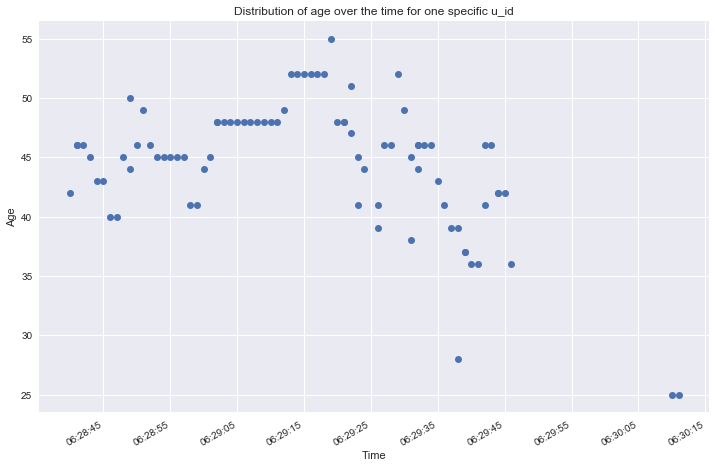

In [225]:
df = eyeq.loc[eyeq.u_id_pasted == 1495297720, :]
plt.figure(figsize=(12, 8))
plt.plot_date(df['local_time'], df['age'])
plt.title("Distribution of age over the time for one specific u_id")
plt.ylabel("Age")
plt.xlabel("Time")
plt.gcf().autofmt_xdate()

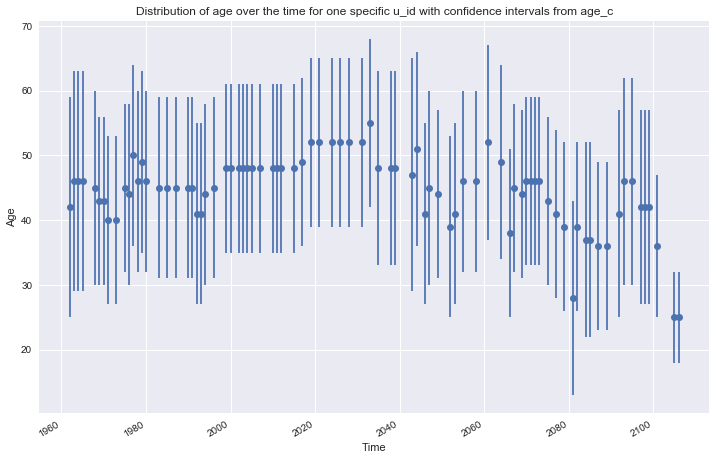

In [215]:
df = eyeq.loc[eyeq.u_id_pasted == 1495297720, :]
plt.figure(figsize=(12, 8))
#plt.plot_date(df['local_time'], df['age'])
plt.errorbar(df['ID'], df['age'], yerr=df['age_c'], fmt='o')
plt.title("Distribution of age over the time for one specific u_id with confidence intervals from age_c")
plt.ylabel("Age")
plt.xlabel("Time")
plt.gcf().autofmt_xdate()

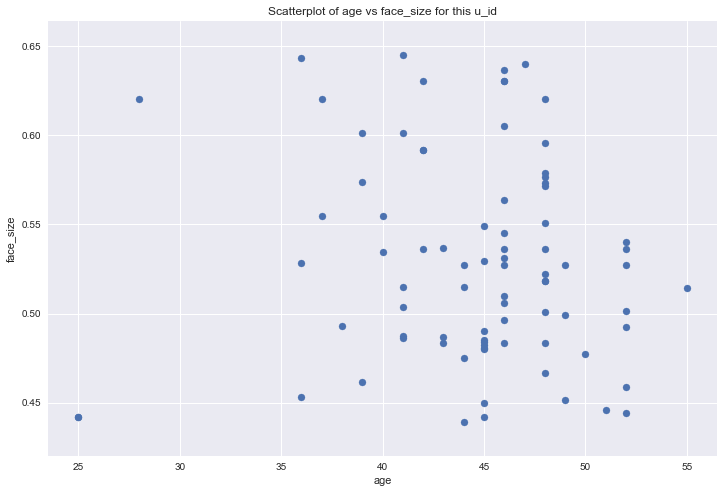

In [221]:
plt.figure(figsize=(12, 8))
plt.scatter(df['age'], df['face_size'])
plt.title("Scatterplot of age vs face_size for this u_id")
plt.ylabel("face_size")
plt.xlabel("age")

- One comment: face_size has maximum value of 21 and minimum value of 0.24. face_size variable is defined as "proxy for closeness to camera". That may indicate that if a consumer is closer to the camera (the fountain), then the face_size is captured larger.  

- The relevant question is that for a given face_size, why the machine captured different ages. 
    - Think about this: find the very first appearance of this consumer. Find his/her face_size and age, gender. Then, try to understand more what values were given to this consumer for these variables in the subsequent fountain usage. 

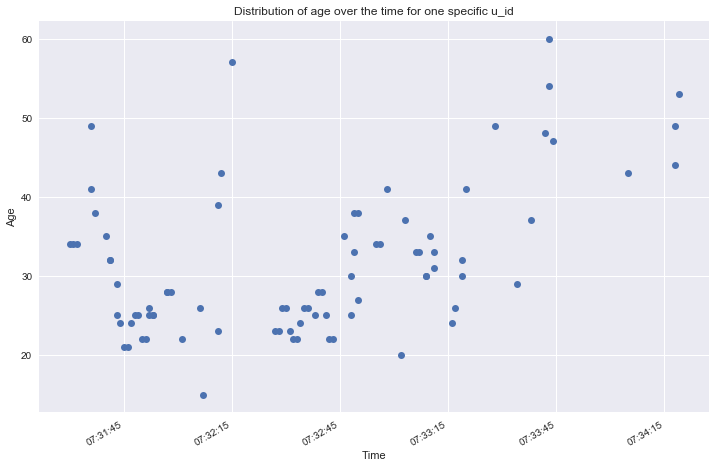

In [170]:
df = eyeq.loc[eyeq.u_id_pasted == 191495301490, :]
plt.figure(figsize=(12, 8))
plt.plot_date(df['local_time'], df['age'])
plt.title("Distribution of age over the time for one specific u_id")
plt.ylabel("Age")
plt.xlabel("Time")
plt.gcf().autofmt_xdate()

- These two scatterplots show that the age has variance for the same u_id. This will arise a concern that which age will represent this customer most correctly.  

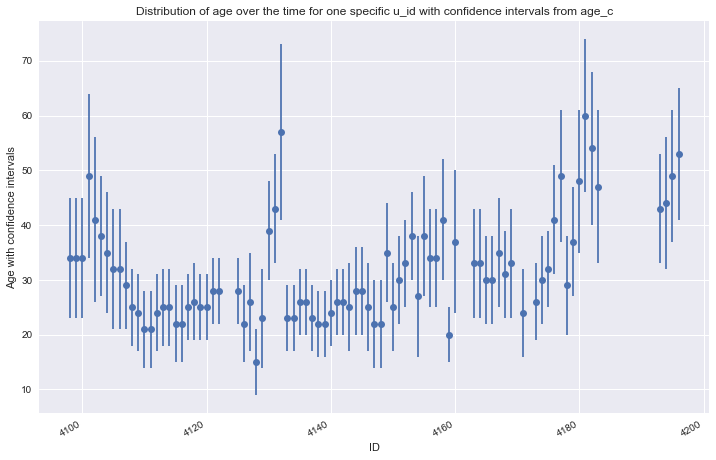

In [212]:
df = eyeq.loc[eyeq.u_id_pasted == 191495301490, :]
plt.figure(figsize=(12, 8))
#plt.plot_date(df['local_time'], df['age'])
plt.errorbar(df['ID'], df['age'], yerr=df['age_c'], fmt='o')
plt.title("Distribution of age over the time for one specific u_id with confidence intervals from age_c")
plt.ylabel("Age with confidence intervals")
plt.xlabel("ID")
plt.gcf().autofmt_xdate()

In [217]:
eyeq.groupby(['u_id_pasted', 'face_size']).agg(['count', 'min', 'max', 'mean', 'std'])['age']

count  min  max       mean        std
u_id_pasted  face_size                                       
0.000000e+00 0.441786       4   26   52  37.750000  10.781929
             0.504585       1   44   44  44.000000        NaN
             0.509660       1   53   53  53.000000        NaN
             0.577704       1   34   34  34.000000        NaN
             0.591814       1   58   58  58.000000        NaN
             0.608467       1   45   45  45.000000        NaN
             0.610903       2   49   61  55.000000   8.485281
             0.640106       1   40   40  40.000000        NaN
             0.645048       1   30   30  30.000000        NaN
             0.649991       3   28   40  32.333333   6.658328
             0.652014       1   44   44  44.000000        NaN
             0.652501       1   44   44  44.000000        NaN
             0.659953       1   30   30  30.000000        NaN
             0.666695       1   32   32  32.000000        NaN
             0.669990       3   39   49  44.666667   5.131601
             0.680103      15   19   61  43.133333  12.551987
             0.680330       1   44   44  44.000000        NaN
             0.690330       1   30   30  30.000000        NaN
             0.700594       1   42   42  42.000000        NaN
             0.703988       1   40   40  40.000000        NaN
             0.705040       1   37   37  37.000000        NaN
             0.710896       2   25   28  26.500000   2.121320
             0.711073       1   45   45  45.000000        NaN
             0.717509       1   30   30  30.000000        NaN
             0.721312       6   34   50  45.166667   5.741661
             0.731804       3   33   45  39.666667   6.110101
             0.732750       1   70   70  70.000000        NaN
             0.732985       1   49   49  49.000000        NaN
             0.742371       3   19   46  33.333333  13.576941
             0.747692       1   36   36  36.000000        NaN
             0.750224       1   45   45  45.000000        NaN
             0.753014       3   33   39  36.000000   3.000000
             0.757117       1   35   35  35.000000        NaN
             0.758828       1   46   46  46.000000        NaN
             0.760160       1   34   34  34.000000        NaN
             0.760261       1   30   30  30.000000        NaN
             0.761998       1   36   36  36.000000        NaN
             0.763733       2   44   67  55.500000  16.263456
             0.763885       1   32   32  32.000000        NaN
             0.774528       2   27   31  29.000000   2.828427
             0.776013       1   51   51  51.000000        NaN
             0.785398       1   41   41  41.000000        NaN
             0.785701       1   74   74  74.000000        NaN
             0.791098       1   33   33  33.000000        NaN
             0.804611       1   24   24  24.000000        NaN
             0.807366       1   35   35  35.000000        NaN
             0.809223       1   43   43  43.000000        NaN
             0.811065       1   35   35  35.000000        NaN
             0.816639       1   22   22  22.000000        NaN
             0.818464       4   33   57  41.500000  10.878113
             0.818501       1   43   43  43.000000        NaN
             0.818805       1   40   40  40.000000        NaN
             0.824808       1   36   36  36.000000        NaN
             0.825607       1   27   27  27.000000        NaN
             0.826090       1   70   70  70.000000        NaN
             0.827901       1   43   43  43.000000        NaN
             0.829637       3   30   36  33.000000   3.000000
             0.829675       1   35   35  35.000000        NaN
             0.829713       1   40   40  40.000000        NaN
             0.837541       1   31   31  31.000000        NaN
             0.838652       1   21   21  21.000000        NaN
             0.840887       5   37   47  39.800000   4.086563
             0.840925       1   12   12  12.000000      

### Synchronizing the two data sources. 

In [241]:
print(len(eyeq['local_time'].unique()))
print(eyeq['local_time'].unique()[0:10])
print(eyeq['local_time'][0:10])

19024
['2017-05-20T02:28:57.000000000' '2017-05-20T02:28:58.000000000'
 '2017-05-20T02:28:59.000000000' '2017-05-20T02:29:00.000000000'
 '2017-05-20T02:29:01.000000000' '2017-05-20T02:29:02.000000000'
 '2017-05-20T02:29:04.000000000' '2017-05-20T02:29:06.000000000'
 '2017-05-20T02:29:07.000000000' '2017-05-20T02:29:08.000000000']
0   2017-05-20 02:28:57
1   2017-05-20 02:28:57
2   2017-05-20 02:28:57
3   2017-05-20 02:28:58
4   2017-05-20 02:28:59
5   2017-05-20 02:28:59
6   2017-05-20 02:29:00
7   2017-05-20 02:29:01
8   2017-05-20 02:29:02
9   2017-05-20 02:29:04
Name: local_time, dtype: datetime64[ns]


In [242]:
print(len(eyeq['Capture Time 15 Second Level'].unique()))
print(eyeq['Capture Time 15 Second Level'].unique()[0:10])
print(eyeq['Capture Time 15 Second Level'][0:10])

3190
['5/20/2017 7:29:00' '5/20/2017 7:29:15' '5/20/2017 7:29:30'
 '5/20/2017 7:29:45' '5/20/2017 7:30:00' '5/20/2017 7:30:15'
 '5/20/2017 7:31:30' '5/20/2017 7:31:45' '5/20/2017 7:33:30'
 '5/20/2017 7:37:15']
0    5/20/2017 7:29:00
1    5/20/2017 7:29:00
2    5/20/2017 7:29:00
3    5/20/2017 7:29:00
4    5/20/2017 7:29:00
5    5/20/2017 7:29:00
6    5/20/2017 7:29:00
7    5/20/2017 7:29:00
8    5/20/2017 7:29:00
9    5/20/2017 7:29:00
Name: Capture Time 15 Second Level, dtype: object


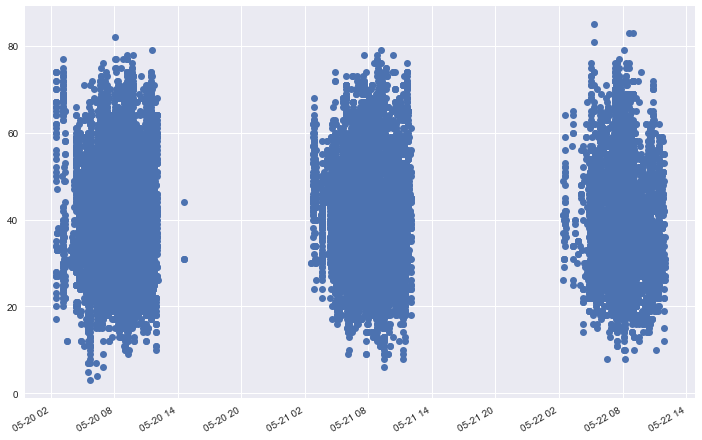

In [243]:
plt.figure(figsize=(12, 8))
plt.plot_date(eyeq['local_time'], eyeq['age'])
plt.gcf().autofmt_xdate()

In [244]:
print(len(spire['Time 15 Second Level'].unique()))

1530


['5/21/17 9:52:45' '5/21/17 9:54:15' '5/21/17 9:55:30' '5/21/17 9:55:45'
 '5/21/17 9:56:00' '5/21/17 9:56:15' '5/21/17 9:56:30' '5/21/17 9:56:45'
 '5/21/17 9:57:00' '5/21/17 9:57:30']


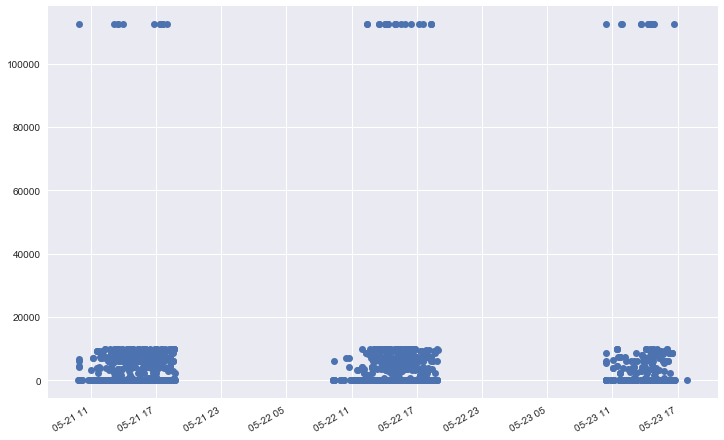

In [245]:
plt.figure(figsize=(12, 8))
plt.plot_date(spire['EQPMT_TX_DTM'], spire['RCPE_ID'])
plt.gcf().autofmt_xdate()
print(spire['Time 15 Second Level'].unique()[0:10])

In [247]:
print(spire['EQPMT_TX_DTM'].unique()[0:10])
print(spire['Time 15 Second Level'].unique()[0:10])

['5/21/2017 9:52' '5/21/2017 9:54' '5/21/2017 9:55' '5/21/2017 9:56'
 '5/21/2017 9:57' '5/21/2017 9:58' '5/21/2017 9:59' '5/21/2017 10:13'
 '5/21/2017 10:46' '5/21/2017 10:56']
['5/21/17 9:52:45' '5/21/17 9:54:15' '5/21/17 9:55:30' '5/21/17 9:55:45'
 '5/21/17 9:56:00' '5/21/17 9:56:15' '5/21/17 9:56:30' '5/21/17 9:56:45'
 '5/21/17 9:57:00' '5/21/17 9:57:30']


In [13]:
spire['Time 15 Second Level'] = list(map(lambda x: datetime.strptime(x, "%m/%d/%y %H:%M:%S"), spire['Time 15 Second Level']))
eyeq['Capture Time 15 Second Level'] = list(map(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), eyeq['Capture Time 15 Second Level']))
eyeq.rename(columns={'Capture Time 15 Second Level':'Capture_Time_15_Second_Level'}, inplace=True) 

In [14]:
#Need to have both dataset have the common column name for the sync.
spire.rename(columns={'Time 15 Second Level':'Capture_Time_15_Second_Level'}, inplace=True)    

In [253]:
#eyeq_sync_spire = eyeq.loc[spire['Capture Time 15 Second Level']]
#This gives an error as the date column cannot be used for indexing??? 

In [21]:
#eyeq_df = eyeq
#eyeq_df['Capture_Time_15_Second_Level'] = list(map(lambda x: datetime.strftime(x, "%m/%d/%y %H:%M:%S"), eyeq_df['Capture_Time_15_Second_Level']))

In [269]:
print(eyeq.dtypes)
print(spire.dtypes)

ID                                       int64
Unnamed: 1                               int64
loc_id                                   int64
place_id                                 int64
u_id                                    object
age                                      int64
age_c                                    int64
happy                                  float64
p_count                                  int64
face_size                              float64
x                                        int64
y                                        int64
f_count                                  int64
capture_time                            object
local_time                      datetime64[ns]
Capture_Time_15_Second_Level    datetime64[ns]
Capture time minute level               object
time_zone                                int64
gender                                 float64
anger                                  float64
surprise                               float64
sad          

In [22]:
eyeq_sync_spire = pd.merge(eyeq, spire, how='inner', on='Capture_Time_15_Second_Level')

In [24]:
print(eyeq_sync_spire.shape)
eyeq_sync_spire.head(10)

(5864, 30)


,ID_x,Unnamed: 1,loc_id,place_id,u_id,age,age_c,happy,p_count,face_size,x,y,f_count,capture_time,local_time,Capture_Time_15_Second_Level,Capture time minute level,time_zone,gender,anger,surprise,sad,u_id_pasted,ID_y,RCPE_NM,EQPMT_TX_DTM,EQPMT_TX_ID,RCPE_ID,INVEN_TX_CMPNT_QTY,Time Minute Level
0,10993,16147,28,36,125-1495378460,44,16,NaN,1,0.441786,96,28,2,5/21/2017 9:54,2017-05-21 04:54:20,2017-05-21 09:54:15,5/21/2017 9:54:00,-5,NaN,NaN,NaN,NaN,1.251495e+12,2,Water,5/21/2017 9:54,24982563,58,10.2326,5/21/17 9:54:00
1,10993,16147,28,36,125-1495378460,44,16,NaN,1,0.441786,96,28,2,5/21/2017 9:54,2017-05-21 04:54:20,2017-05-21 09:54:15,5/21/2017 9:54:00,-5,NaN,NaN,NaN,NaN,1.251495e+12,3,Water,5/21/2017 9:54,24982594,58,8.6047,5/21/17 9:54:00
2,10994,16146,28,36,125-1495378460,43,15,25.0,1,0.441786,97,28,2,5/21/2017 9:54,2017-05-21 04:54:21,2017-05-21 09:54:15,5/21/2017 9:54:00,-5,1.0,NaN,NaN,NaN,1.251495e+12,2,Water,5/21/2017 9:54,24982563,58,10.2326,5/21/17 9:54:00
3,10994,16146,28,36,125-1495378460,43,15,25.0,1,0.441786,97,28,2,5/21/2017 9:54,2017-05-21 04:54:21,2017-05-21 09:54:15,5/21/2017 9:54:00,-5,1.0,NaN,NaN,NaN,1.251495e+12,3,Water,5/21/2017 9:54,24982594,58,8.6047,5/21/17 9:54:00
4,10995,16143,28,36,126-1495378537,54,13,NaN,1,0.441786,43,6,3,5/21/2017 9:55,2017-05-21 04:55:38,2017-05-21 09:55:45,5/21/2017 9:56:00,-5,NaN,NaN,NaN,NaN,1.261495e+12,7,Sweet Tea,5/21/2017 9:55,24982509,43,1.5453,5/21/17 9:56:00
5,10995,16143,28,36,126-1495378537,54,13,NaN,1,0.441786,43,6,3,5/21/2017 9:55,2017-05-21 04:55:38,2017-05-21 09:55:45,5/21/2017 9:56:00,-5,NaN,NaN,NaN,NaN,1.261495e+12,8,Aquafina Sparkling,5/21/2017 9:55,24982597,38,26.7442,5/21/17 9:56:00
6,10996,16144,28,36,126-1495378537,54,13,NaN,1,0.458300,43,6,1,5/21/2017 9:55,2017-05-21 04:55:38,2017-05-21 09:55:45,5/21/2017 9:56:00,-5,-1.0,NaN,NaN,NaN,1.261495e+12,7,Sweet Tea,5/21/2017 9:55,24982509,43,1.5453,5/21/17 9:56:00
7,10996,16144,28,36,126-1495378537,54,13,NaN,1,0.458300,43,6,1,5/21/2017 9:55,2017-05-21 04:55:38,2017-05-21 09:55:45,5/21/2017 9:56:00,-5,-1.0,NaN,NaN,NaN,1.261495e+12,8,Aquafina Sparkling,5/21/2017 9:55,24982597,38,26.7442,5/21/17 9:56:00
8,10997,16145,28,36,126-1495378537,54,13,NaN,1,0.450006,43,6,1,5/21/2017 9:55,2017-05-21 04:55:38,2017-05-21 09:55:45,5/21/2017 9:56:00,-5,1.0,NaN,NaN,NaN,1.261495e+12,7,Sweet Tea,5/21/2017 9:55,24982509,43,1.5453,5/21/17 9:56:00
9,10997,16145,28,36,126-1495378537,54,13,NaN,1,0.450006,43,6,1,5/21/2017 9:55,2017-05-21 04:55:38,2017-05-21 09:55:45,5/21/2017 9:56:00,-5,1.0,NaN,NaN,NaN,1.261495e+12,8,Aquafina Sparkling,5/21/2017 9:55,24982597,38,26.7442,5/21/17 9:56:00
